### ssGSEA analysis on data from TCGA-GBM dataset

In [1]:
library(matrixStats)
library(circlize)
library(ComplexHeatmap)
library(data.table)
library(SummarizedExperiment)
library(S4Vectors)
library(GenomicRanges)
library(IRanges)
library(dplyr)

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.18.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps in

In [2]:
#set working directory (location where TCGA data is stored)
setwd("/scratch/user/s4436039/TCGA_Data")

In [3]:
# load in data (data was previously downloaded using the TCGAbiolinks package in R and saved as an RDS object)
TCGA_GBM <- readRDS("TCGA_GBM.rds")
TCGA_GBM
summary(TCGA_GBM)

class: RangedSummarizedExperiment 
dim: 60660 176 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(176): TCGA-06-0211-01B-01R-1849-01
  TCGA-06-0211-02A-02R-2005-01 ... TCGA-06-5856-01A-01R-1849-01
  TCGA-12-0618-01A-01R-1849-01
colData names(109): barcode patient ...
  paper_Telomere.length.estimate.in.blood.normal..Kb.
  paper_Telomere.length.estimate.in.tumor..Kb.

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [4]:
unique(TCGA_GBM$sample_type)

[1] "Primary Tumor"       "Recurrent Tumor"     "Solid Tissue Normal"

In [5]:
table(colData(TCGA_GBM)$sample_type)


      Primary Tumor     Recurrent Tumor Solid Tissue Normal 
                158                  13                   5 

In [6]:
# Subset object
primary <- TCGA_GBM[, colData(TCGA_GBM)$sample_type != "Solid Tissue Normal"]

In [7]:
table(colData(primary)$sample_type)


  Primary Tumor Recurrent Tumor 
            158              13 

In [8]:
summary(primary)

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [9]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [10]:
#view the different assays stored
assays(primary)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [11]:
#for this analysis using the tpm_unstrand assay 
dim(assays(primary)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(primary)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660   171

,TCGA-06-0211-01B-01R-1849-01,TCGA-06-0211-02A-02R-2005-01,TCGA-06-0130-01A-01R-1849-01
ENSG00000000003.15,94.2605,68.5342,40.8655
ENSG00000000005.6,0.2525,0.3854,0.1024
ENSG00000000419.13,94.5335,119.5198,108.0601


In [12]:
#convert to matrix
data = as.matrix(data)

In [13]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [14]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
  1.844   0.117   1.972 

In [15]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-06-0211-01B-01R-1849-01,0.3556704
TCGA-06-0211-02A-02R-2005-01,0.3797577
TCGA-06-0130-01A-01R-1849-01,0.3902023
TCGA-06-0132-01A-02R-1849-01,0.3714838
TCGA-16-1045-01B-01R-1850-01,0.3780718
TCGA-06-0125-01A-01R-1849-01,0.3572269


In [16]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]   1 171

TCGA-06-0211-01B-01R-1849-01 TCGA-06-0211-02A-02R-2005-01 
                  -0.5908879                    1.3549576 
TCGA-06-0130-01A-01R-1849-01 TCGA-06-0132-01A-02R-1849-01 
                   2.1987108                    0.6865687 
TCGA-16-1045-01B-01R-1850-01 
                   1.2187720

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [17]:
#to view the types of data stored for each sample 
colnames(colData(primary))

[1] "barcode"                                            
  [2] "patient"                                            
  [3] "sample"                                             
  [4] "shortLetterCode"                                    
  [5] "definition"                                         
  [6] "sample_submitter_id"                                
  [7] "sample_type_id"                                     
  [8] "tumor_descriptor"                                   
  [9] "sample_id"                                          
 [10] "sample_type"                                        
 [11] "composition"                                        
 [12] "state"                                              
 [13] "preservation_method"                                
 [14] "intermediate_dimension"                             
 [15] "pathology_report_uuid"                              
 [16] "submitter_id"                                       
 [17] "shortest_dimension"                                 
 [18] "specimen_type"                                      
 [19] "longest_dimension"                                  
 [20] "is_ffpe"                                            
 [21] "tissue_type"                                        
 [22] "synchronous_malignancy"                             
 [23] "morphology"                                         
 [24] "days_to_diagnosis"                                  
 [25] "treatments"                                         
 [26] "last_known_disease_status"                          
 [27] "tissue_or_organ_of_origin"                          
 [28] "days_to_last_follow_up"                             
 [29] "age_at_diagnosis"                                   
 [30] "primary_diagnosis"                                  
 [31] "classification_of_tumor"                            
 [32] "diagnosis_id"                                       
 [33] "prior_malignancy"                                   
 [34] "year_of_diagnosis"                                  
 [35] "icd_10_code"                                        
 [36] "site_of_resection_or_biopsy"                        
 [37] "prior_treatment"                                    
 [38] "tumor_grade"                                        
 [39] "progression_or_recurrence"                          
 [40] "alcohol_history"                                    
 [41] "exposure_id"                                        
 [42] "race"                                               
 [43] "gender"                                             
 [44] "ethnicity"                                          
 [45] "vital_status"                                       
 [46] "age_at_index"                                       
 [47] "days_to_birth"                                      
 [48] "year_of_birth"                                      
 [49] "demographic_id"                                     
 [50] "days_to_death"                                      
 [51] "year_of_death"                                      
 [52] "bcr_patient_barcode"                                
 [53] "primary_site"                                       
 [54] "project_id"                                         
 [55] "disease_type"                                       
 [56] "name"                                               
 [57] "releasable"                                         
 [58] "released"                                           
 [59] "paper_patient"                                      
 [60] "paper_Tissue.source.site"                           
 [61] "paper_Study"                                        
 [62] "paper_BCR"                                          
 [63] "paper_Whole.exome"                                  
 [64] "paper_Whole.genome"                                 
 [65] "paper_RNAseq"                                       
 [66] "paper_SNP6"                                         
 [67] "paper_U133a"                       

In [18]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 171   1

,mat
TCGA-06-0211-01B-01R-1849-01,-0.5908879
TCGA-06-0211-02A-02R-2005-01,1.3549576
TCGA-06-0130-01A-01R-1849-01,2.1987108
TCGA-06-0132-01A-02R-1849-01,0.6865687
TCGA-16-1045-01B-01R-1850-01,1.2187720
TCGA-06-0125-01A-01R-1849-01,-0.4651447


In [19]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(primary)$days_to_death
names(death_days) <- row.names(colData(primary))
followup_days <- colData(primary)$days_to_last_follow_up
names(followup_days) <- row.names(colData(primary))
status <- colData(primary)$vital_status
names(status) <- row.names(colData(primary))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-06-0211-01B-01R-1849-01,-0.590887865714034,360,Dead,360
TCGA-06-0211-02A-02R-2005-01,1.35495756465984,360,Dead,360
TCGA-06-0130-01A-01R-1849-01,2.19871078964988,320,Dead,394
TCGA-06-0132-01A-02R-1849-01,0.686568650530201,570,Dead,771
TCGA-16-1045-01B-01R-1850-01,1.21877201164056,883,Dead,883
TCGA-06-0125-01A-01R-1849-01,-0.465144747955262,1439,Dead,1448


In [20]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-06-0211-01B-01R-1849-01,-0.590887865714034,360,Dead,360,TRUE
TCGA-06-0211-02A-02R-2005-01,1.35495756465984,360,Dead,360,TRUE
TCGA-06-0130-01A-01R-1849-01,2.19871078964988,320,Dead,394,TRUE
TCGA-06-0132-01A-02R-1849-01,0.686568650530201,570,Dead,771,TRUE
TCGA-16-1045-01B-01R-1850-01,1.21877201164056,883,Dead,883,TRUE
TCGA-06-0125-01A-01R-1849-01,-0.465144747955262,1439,Dead,1448,TRUE


In [21]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-06-0211-01B-01R-1849-01,-0.590887865714034,360,Dead,360,TRUE,360
TCGA-06-0211-02A-02R-2005-01,1.35495756465984,360,Dead,360,TRUE,360
TCGA-06-0130-01A-01R-1849-01,2.19871078964988,320,Dead,394,TRUE,394
TCGA-06-0132-01A-02R-1849-01,0.686568650530201,570,Dead,771,TRUE,771
TCGA-16-1045-01B-01R-1850-01,1.21877201164056,883,Dead,883,TRUE,883
TCGA-06-0125-01A-01R-1849-01,-0.465144747955262,1439,Dead,1448,TRUE,1448


In [22]:
# load packages needed for survival analysis
library(survival)
library(survminer)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma




In [23]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-06-0211-01B-01R-1849-01,-0.590887865714034,360,Dead,360,TRUE,360,Middle
TCGA-06-0211-02A-02R-2005-01,1.35495756465984,360,Dead,360,TRUE,360,Top 33%
TCGA-06-0130-01A-01R-1849-01,2.19871078964988,320,Dead,394,TRUE,394,Top 33%
TCGA-06-0132-01A-02R-1849-01,0.686568650530201,570,Dead,771,TRUE,771,Top 33%
TCGA-16-1045-01B-01R-1850-01,1.21877201164056,883,Dead,883,TRUE,883,Top 33%
TCGA-06-0125-01A-01R-1849-01,-0.465144747955262,1439,Dead,1448,TRUE,1448,Middle


In [24]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-06-0211-02A-02R-2005-01,1.35495756465984,360,Dead,360,TRUE,360,Top 33%
TCGA-06-0130-01A-01R-1849-01,2.19871078964988,320,Dead,394,TRUE,394,Top 33%
TCGA-06-0132-01A-02R-1849-01,0.686568650530201,570,Dead,771,TRUE,771,Top 33%
TCGA-16-1045-01B-01R-1850-01,1.21877201164056,883,Dead,883,TRUE,883,Top 33%
TCGA-06-0125-02A-11R-2005-01,0.874213555425422,1439,Dead,1448,TRUE,1448,Top 33%
TCGA-06-0139-01A-01R-1849-01,1.58362443867522,327,Dead,362,TRUE,362,Top 33%


In [25]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

                   n events median 0.95LCL 0.95UCL
strata=Bottom 33% 24     18    270     150     737
strata=Top 33%    58     51    360     300     385

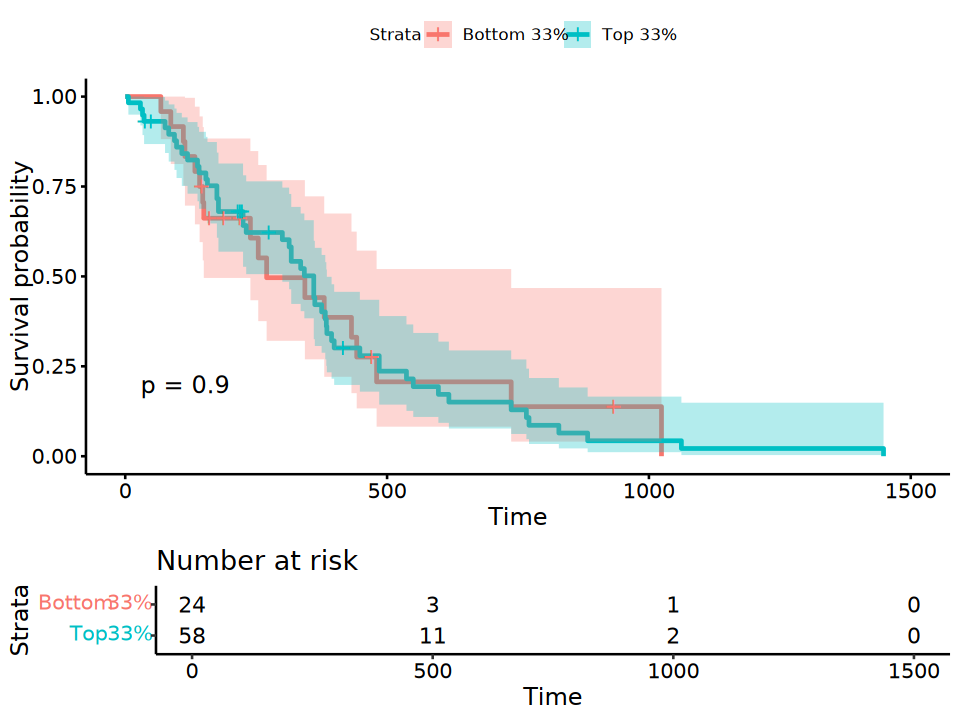

In [26]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)